## Setup

In [1]:
# Common imports
import numpy as np
import os

# Plot pretty
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT = "."
PROJECT_ID = "knn"
IMG_PATH = os.path.join(PROJECT_ROOT, "images", PROJECT_ID)
os.makedirs(IMG_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMG_PATH, fig_id + "." + fig_extension)
    print("Saving figure...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore",message="^internal gelsd")

## Get the data

In [2]:
import os
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/TuZhechen/hello_world/main/"
DATA_URL = DOWNLOAD_ROOT + "kaggles/winequality/winequality_red.csv"
LOCAL_PATH = "./winequality"

def fetch_data(data_url=DATA_URL, local_path=LOCAL_PATH):
    if not os.path.isdir(local_path):
        os.makedirs(local_path)
    target_path = os.path.join(local_path, "wines_knn.csv")
    urllib.request.urlretrieve(data_url, target_path)

In [3]:
fetch_data()

In [4]:
import pandas as pd

def load_data(local_path=LOCAL_PATH):
    csv_path = os.path.join(local_path, "wines_knn.csv")
    return pd.read_csv(csv_path)

## Data Review

In [5]:
wines = load_data()
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
wines.columns = wines.columns.str.replace(' ', '_')
wines = wines.astype({col: 'float32' 
                      for col in wines.select_dtypes(include='float64').columns})
wines.quality = wines.quality.astype('uint8')
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float32
 1   volatile_acidity      1599 non-null   float32
 2   citric_acid           1599 non-null   float32
 3   residual_sugar        1599 non-null   float32
 4   chlorides             1599 non-null   float32
 5   free_sulfur_dioxide   1599 non-null   float32
 6   total_sulfur_dioxide  1599 non-null   float32
 7   density               1599 non-null   float32
 8   pH                    1599 non-null   float32
 9   sulphates             1599 non-null   float32
 10  alcohol               1599 non-null   float32
 11  quality               1599 non-null   uint8  
dtypes: float32(11), uint8(1)
memory usage: 70.4 KB


Saving figure... attr_histo


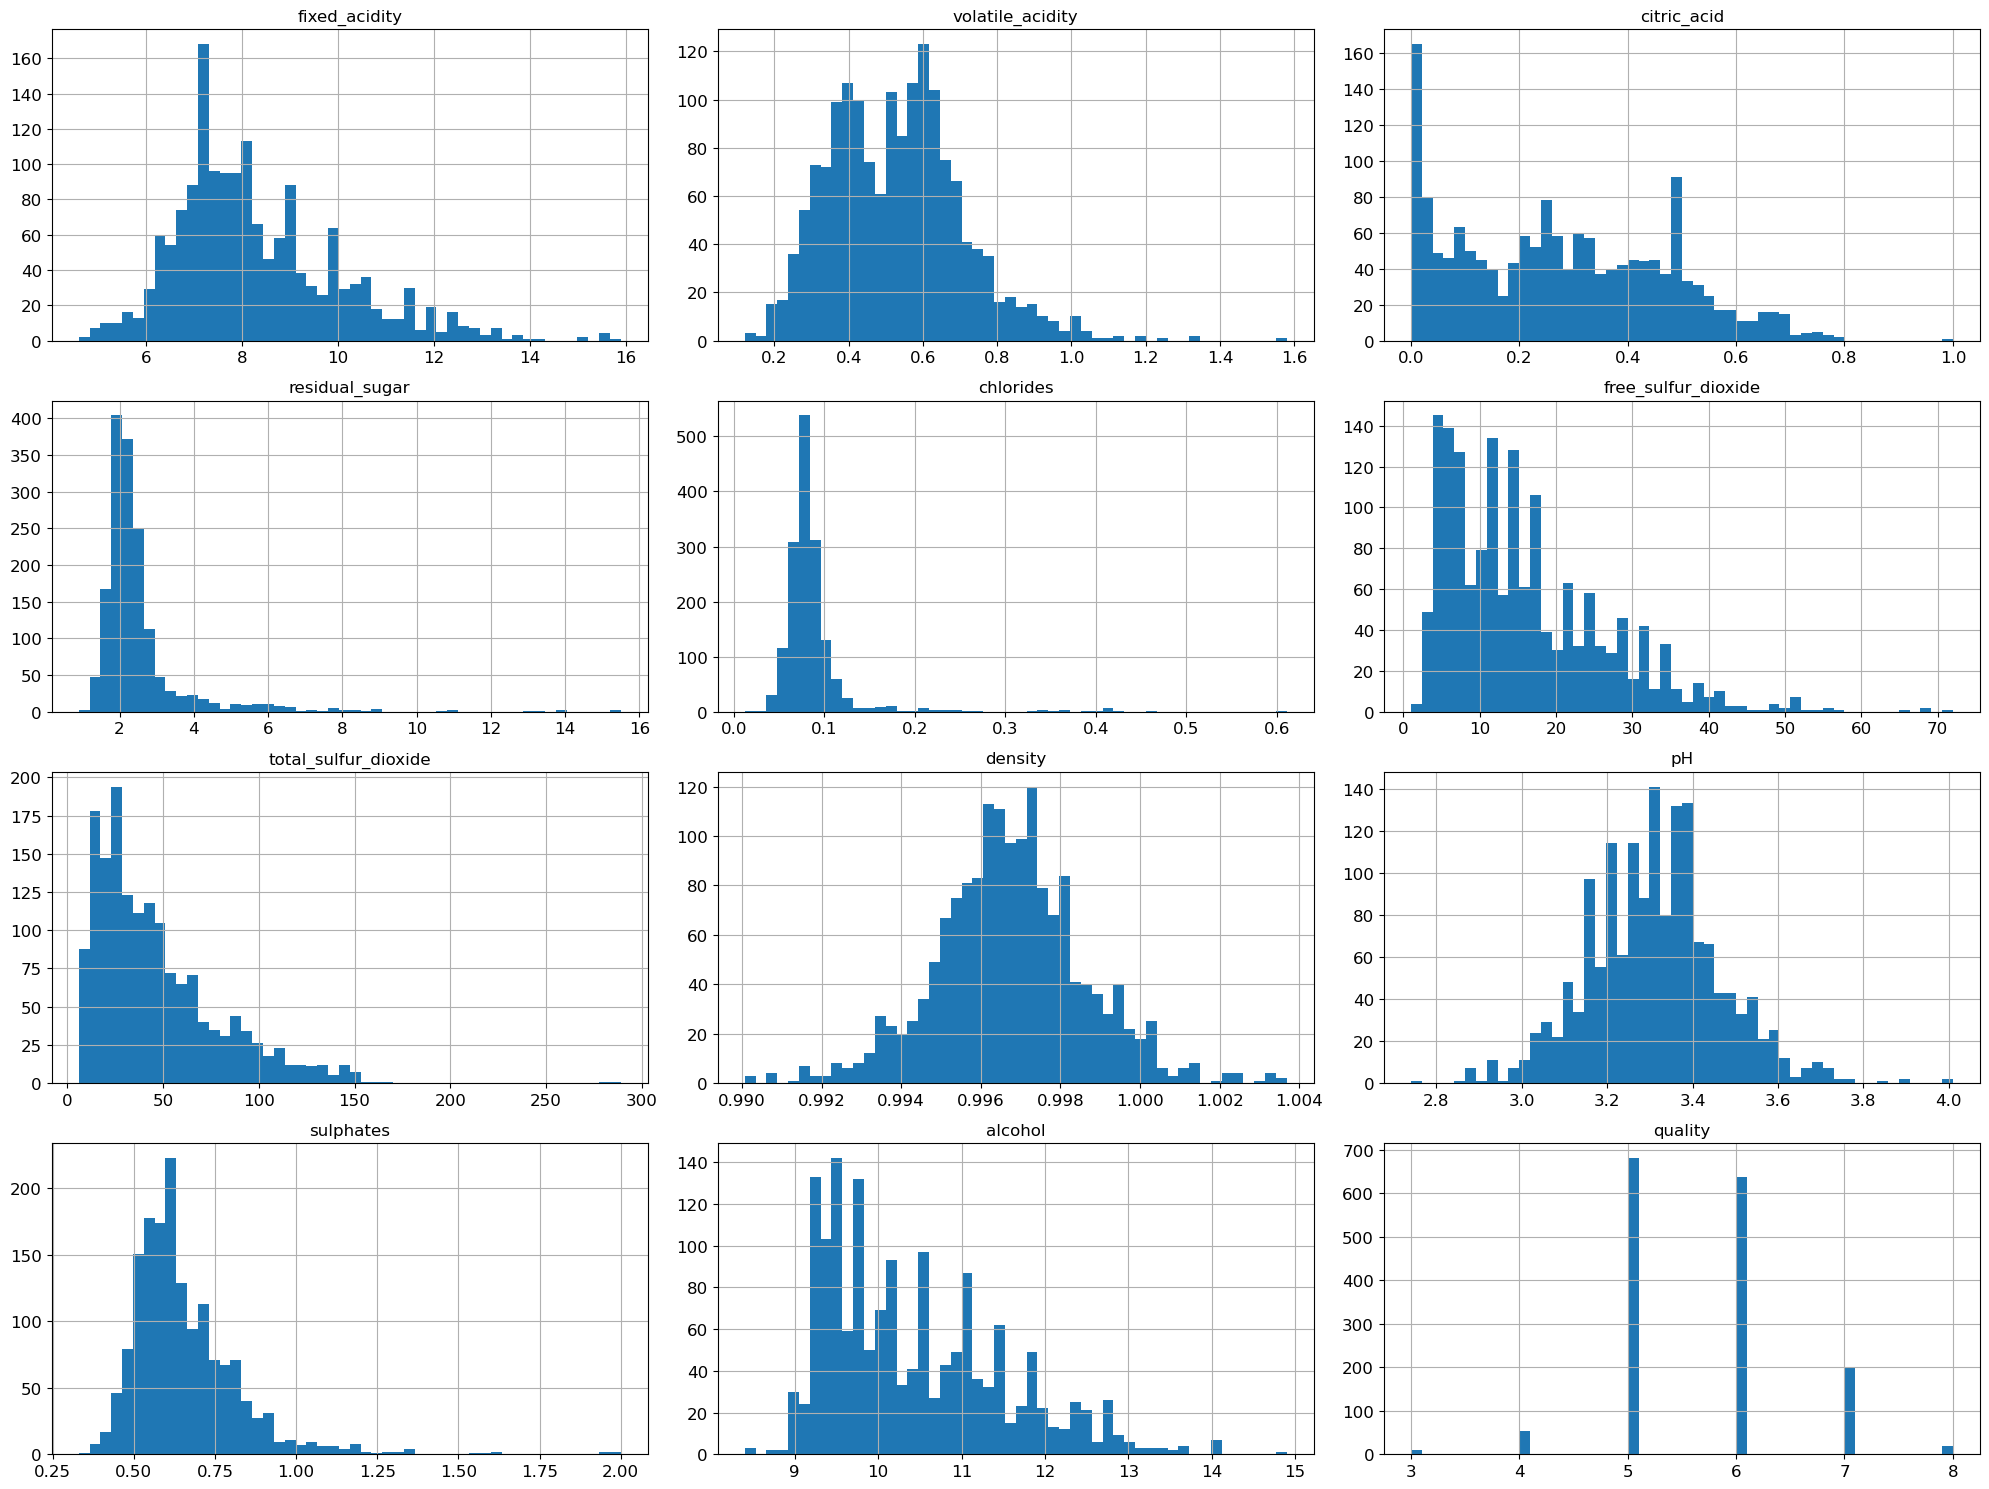

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
wines.hist(bins=50, figsize=(20,15))
save_fig("attr_histo")
plt.show()

Saving figure... scatter_plot_basicinfo


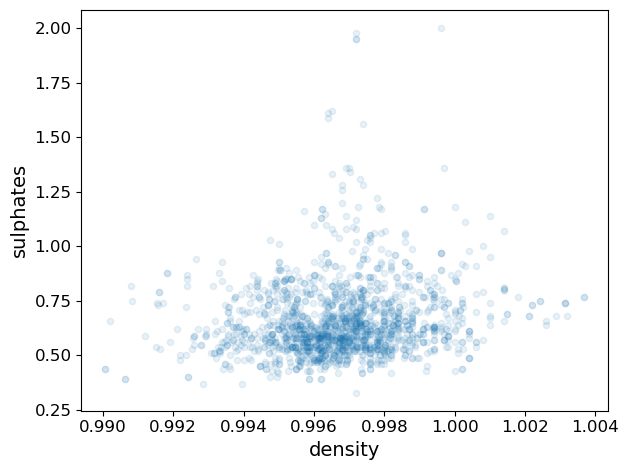

In [9]:
wines.plot(kind="scatter", x="density", y="sulphates", alpha=0.1)
save_fig("scatter_plot_basicinfo")

Saving figure... scatter_plot_w_quality


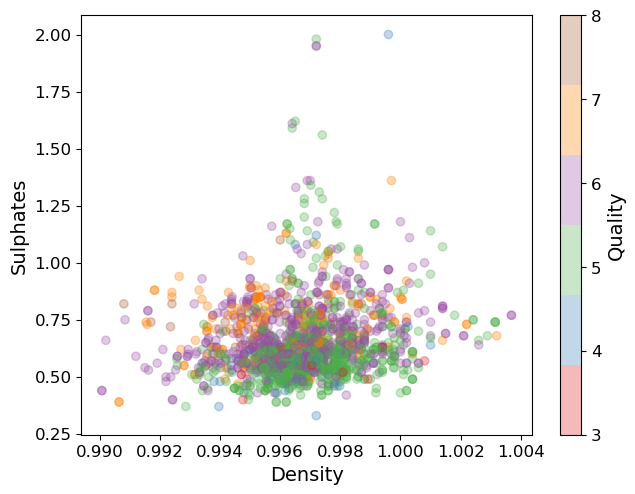

In [10]:
from matplotlib.colors import ListedColormap

quality_cmap = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628'])
plt.scatter(x=wines.density, y=wines.sulphates, c=wines.quality,
            alpha=0.3, cmap=quality_cmap)
plt.colorbar(ticks=[3, 4, 5, 6, 7, 8], label='Quality')
save_fig("scatter_plot_w_quality")
plt.xlabel('Density')
plt.ylabel('Sulphates')
plt.show()

In [12]:
corr_mat = wines.corr()
corr_mat['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric_acid             0.226373
fixed_acidity           0.124052
residual_sugar          0.013732
free_sulfur_dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total_sulfur_dioxide   -0.185100
volatile_acidity       -0.390558
Name: quality, dtype: float64

In [20]:
self_corr = wines.drop('quality', axis=1).corr()
self_corr = self_corr.applymap(lambda x: 0 if x==1 else x)
self_corr = self_corr.applymap(lambda x: abs(x))
max_corr  = []
max_corr_idx = []
for col in self_corr.columns:
    max_corr.append(self_corr[col].max())
    max_corr_idx.append(self_corr[col].idxmax())
self_corr['max_corr'] = max_corr
self_corr['max_corr_idx'] = max_corr_idx
self_corr[['max_corr', 'max_corr_idx']]

,max_corr,max_corr_idx
fixed_acidity,0.682978,pH
volatile_acidity,0.552496,citric_acid
citric_acid,0.671703,fixed_acidity
residual_sugar,0.355283,density
chlorides,0.371260,sulphates
free_sulfur_dioxide,0.667666,total_sulfur_dioxide
total_sulfur_dioxide,0.667666,free_sulfur_dioxide
density,0.668047,fixed_acidity
pH,0.682978,fixed_acidity
sulphates,0.371260,chlorides


## Sampling

In [64]:
attr_selected = ['alcohol', 'chlorides', 'sulphates', 'citric_acid', 'total_sulfur_dioxide', 'residual_sugar', 'quality']

from sklearn.model_selection import train_test_split
X = wines[attr_selected]
train_set, test_set = train_test_split(X, test_size=0.2, random_state=42)
X.drop('quality', axis=1, inplace=True)
test_set.head()

C:\Users\10341\AppData\Local\Temp\ipykernel_7232\920406840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('quality', axis=1, inplace=True)


,alcohol,chlorides,sulphates,citric_acid,total_sulfur_dioxide,residual_sugar,quality
803,9.6,0.114,0.66,0.08,46.0,2.50,6
124,9.5,0.082,0.48,0.17,102.0,1.60,5
350,9.9,0.107,0.98,0.22,34.0,2.70,6
682,9.8,0.078,0.54,0.31,58.0,2.25,5
1326,10.6,0.077,0.60,0.24,34.0,1.70,6


In [65]:
x_train = train_set.drop('quality', axis=1)
y_train = train_set.quality
x_test = test_set.drop('quality', axis=1)
y_test = test_set.quality

## Functions and classes

In [66]:
cov = np.cov(X.T)
def malanobis_distance(x, y, sigma=cov):
    x_minus_y = x - y
    invD = np.linalg.inv(sigma)
    return np.sqrt(np.dot(np.dot(x_minus_y, invD), x_minus_y.T))

In [67]:
class KNN_Bruteforce():
    def __init__(self, k=5):
        self.k = k
    def fit(self, x=x_train, y=y_train):
        self.x = x
        self.y = y
    def predict(self, x=x_test):
        y_pred = []
        for x_i in x.values:
            distances = []
            for x_j in self.x.values:
                distances.append(malanobis_distance(x_i, x_j))
            distances = np.array(distances)
            k_nearest = self.y.values[distances.argsort()[:self.k]]
            y_pred.append(np.bincount(k_nearest).argmax())
        return np.array(y_pred)

In [75]:
class Node():
    def __init__(self, data):
        self.left = None
        self.right = None
        self.data = data

class KDTree():
    def __init__(self, data):
        self.kd = data.shape[1]
        self.root = self.build(data)

    # recusively divide the data into two parts
    def build(self, X, depth=0):
        if len(X) == 0:
            return None
        axis = depth % self.kd
        X = X[X[:, axis].argsort()]
        median = len(X) // 2
        node = Node(X[median])
        node.left = self.build(X[:median], depth+1)
        node.right = self.build(X[median+1:], depth+1)
        return node

    def search(self, x, k=1):
        self.nearest = []
        def travel(node, depth=0):
            if node is None:
                return
            axis = depth % self.kd
            # search the side of the splitting plane that x is in
            if x[axis] < node.data[axis]:
                travel(node.left, depth+1)
            else:
                travel(node.right, depth+1)
            # update nearest nodes list
            dist = malanobis_distance(x, node.data)
            if len(self.nearest) < k or dist < max(d for d, n in self.nearest):
                if len(self.nearest) == k:
                    self.nearest.remove(max(self.nearest, key=lambda x: x[0]))
                self.nearest.append((dist, node.data))
            # search the other side of the splitting plane if the superball crosses the plane
            if abs(x[axis] - node.data[axis]) < min(d for d, n in self.nearest):
                if x[axis] < node.data[axis]:
                    travel(node.right, depth+1)
                else:
                    travel(node.left, depth+1)
        travel(self.root)
        return [n for d, n in sorted(self.nearest, key=lambda x: x[0])]

In [76]:
class KNN_KDTree():
    def __init__(self, k=5):
        self.k = k
    def fit(self, x=x_train, y=y_train):
        self.x = x
        self.y = y
        self.kdtree = KDTree(x.values)
    def predict(self, x=x_test):
        y_pred = []
        for x_i in x.values:
            k_nearest_points = self.kdtree.search(x_i, self.k)
            k_nearest_points = np.array(k_nearest_points)
            k_nearest_indices = []
            for point in k_nearest_points:
                k_nearest_indices.append(np.where((self.x == point).all(axis=1))[0][0])
            k_nearest_labels = self.y.values[k_nearest_indices]
            y_pred.append(np.bincount(k_nearest_labels).argmax())
        return np.array(y_pred)

## Model fitting

In [77]:
naive_knn = KNN_Bruteforce()
naive_knn.fit()
naive_knn_pred = naive_knn.predict()
error_rate = np.mean(naive_knn_pred != y_test)
print('Naive KNN error rate: ', error_rate)

Naive KNN error rate:  0.415625


In [78]:
kdtree_knn = KNN_KDTree()
kdtree_knn.fit()
kdtree_knn_pred = kdtree_knn.predict()
error_rate = np.mean(kdtree_knn_pred != y_test)
print('KDTree KNN error rate: ', error_rate)


KDTree KNN error rate:  0.4125


In [79]:
def knn_test(k, apply_tree=False):
    if apply_tree:
        knn = KNN_KDTree(k)
    else:
        knn = KNN_Bruteforce(k)
    knn.fit()
    knn_pred = knn.predict()
    error_rate = np.mean(knn_pred != y_test)
    print(f'k = {k}, tree: {apply_tree}, error rate: {error_rate: .2%}')

In [81]:
def knn_summary():
    for k in range(1, 21):
        knn_test(k)
        knn_test(k, apply_tree=True)

In [82]:
knn_summary()

k = 1, tree: False, error rate:  36.88%
k = 1, tree: True, error rate:  37.81%
k = 2, tree: False, error rate:  46.88%
k = 2, tree: True, error rate:  46.88%
k = 3, tree: False, error rate:  43.75%
k = 3, tree: True, error rate:  42.81%
k = 4, tree: False, error rate:  40.62%
k = 4, tree: True, error rate:  39.06%
k = 5, tree: False, error rate:  41.56%
k = 5, tree: True, error rate:  41.25%
k = 6, tree: False, error rate:  40.94%
k = 6, tree: True, error rate:  39.06%
k = 7, tree: False, error rate:  44.06%
k = 7, tree: True, error rate:  42.19%
k = 8, tree: False, error rate:  41.25%
k = 8, tree: True, error rate:  40.62%
k = 9, tree: False, error rate:  41.88%
k = 9, tree: True, error rate:  41.25%
k = 10, tree: False, error rate:  42.19%
k = 10, tree: True, error rate:  41.88%
k = 11, tree: False, error rate:  42.81%
k = 11, tree: True, error rate:  41.88%
k = 12, tree: False, error rate:  43.44%
k = 12, tree: True, error rate:  42.19%
k = 13, tree: False, error rate:  43.75%
k = 1